In [1]:
#Collab bootstrapping for accessing files from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [2]:
#Get test_medium.csv
downloaded = drive.CreateFile({'id':"1nM4xOSa_WPF_9gmFPVMX0LgSXIduTk_X"})
downloaded.GetContentFile('test_medium.csv')

#Get train_medium.csv
downloaded = drive.CreateFile({'id':"1W5RFr2-ZKo-g3nYtPZP2k2-ePHkOKsP2"})
downloaded.GetContentFile('train_medium.csv')

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab

In [4]:
#Hyper-parameters and other constants definition
MAX_DOCUMENT_LENGTH = 100
HIDDEN_SIZE=20
MAX_LABEL = 15

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

In [5]:
# Read data with [character] + other helper functions (from starter code)
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test

In [6]:
#Load the dataset (both train and test set) and conduct necessary preprocessing
x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [7]:
print(y_train)

tf.Tensor([ 7  9  4 ...  9  6 12], shape=(5600,), dtype=int64)


In [8]:
# Model definition (using inheritance to base Model from keras library)
tf.keras.backend.set_floatx('float32')
class CharRNN(Model):
    def __init__(self, vocab_size, hidden_dim, cell_type, cell_num):
        super(CharRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.cell_num = cell_num
        # Weight variables and RNN cell
        # Cell type check

        if cell_type == 'rnn':
            cell_fn = tf.keras.layers.SimpleRNNCell
        elif cell_type == 'gru':
            cell_fn = tf.keras.layers.GRUCell
        elif cell_type == 'lstm':
            cell_fn = tf.keras.layers.LSTMCell
        
        #Stacked RNN if needed
        cells = []
        for i in range(cell_num):
            cells.append(cell_fn(self.hidden_dim))
        cells = tf.keras.layers.StackedRNNCells(cells)
        
        #Effective RNN cell to feed the model forward
        self.rnn = tf.keras.layers.RNN(
            cells,
            unroll=True)

        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = tf.one_hot(x, one_hot_size)
        x = self.rnn(x)
        x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [9]:
# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr,clipvalue=2)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [10]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(label, out)

# Testing function
def test_step(model, x, label, drop_rate):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [11]:
#TOCHANGE
cell_type_list = ['gru','lstm','rnn'] #Part a
cell_num = 1
test_acc_dict={}
train_loss_dict={}

for rnn_cell in cell_type_list:
    print("Building %s model with %s cells"%(rnn_cell, cell_num))
    model = CharRNN(256, HIDDEN_SIZE, cell_type = rnn_cell, cell_num = cell_num)
    print("Built %s model with %s cells"%(rnn_cell, cell_num))
    #Training process
    test_acc = []
    train_entropy_loss = []
    print("Starting training for %s model with %s cells"%(rnn_cell, cell_num))
    for epoch in range(no_epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        for character_ids, labels in train_ds:
            train_step(model, character_ids, labels, drop_rate=0)

        for character_ids, labels in test_ds:
            test_step(model, character_ids, labels, drop_rate=0)

        test_acc.append(test_accuracy.result())
        train_entropy_loss.append(train_loss.result())
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print (template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result(),
                              test_loss.result(),
                              test_accuracy.result()))
    #Update the dictionary of result once done
    test_acc_dict[rnn_cell] = test_acc
    train_loss_dict[rnn_cell] = train_entropy_loss
    print("Finished training of %s model with %s cells"%(rnn_cell, cell_num))


Building gru model with 1 cells
Built gru model with 1 cells
Starting training for gru model with 1 cells
Epoch 1, Loss: 2.6426498889923096, Accuracy: 0.09000000357627869, Test Loss: 2.582172155380249, Test Accuracy: 0.1071428582072258
Epoch 2, Loss: 2.501220226287842, Accuracy: 0.14196428656578064, Test Loss: 2.4070053100585938, Test Accuracy: 0.1371428519487381
Epoch 3, Loss: 2.2892045974731445, Accuracy: 0.1976785659790039, Test Loss: 2.2880265712738037, Test Accuracy: 0.17000000178813934
Epoch 4, Loss: 2.1175618171691895, Accuracy: 0.2467857152223587, Test Loss: 2.0288121700286865, Test Accuracy: 0.28857141733169556
Epoch 5, Loss: 1.862313151359558, Accuracy: 0.34285715222358704, Test Loss: 1.8316298723220825, Test Accuracy: 0.3571428656578064
Epoch 6, Loss: 1.6596630811691284, Accuracy: 0.42250001430511475, Test Loss: 1.6293835639953613, Test Accuracy: 0.427142858505249
Epoch 7, Loss: 1.5339831113815308, Accuracy: 0.4610714316368103, Test Loss: 1.514061450958252, Test Accuracy: 0.

In [12]:
#Double checking the result dictionary
test_acc_dict.keys()

dict_keys(['gru', 'lstm', 'rnn'])

In [13]:
#Print out all test_accuracy max and min train loss
for cell_type in cell_type_list:
  print("%s model of %s cells, gradient clipped: test acc - %s , train loss - %s "%(cell_type,cell_num, np.max(test_acc_dict[cell_type]), np.min(train_loss_dict[cell_type])))

gru model of 1 cells, gradient clipped: test acc - 0.71 , train loss - 0.13945472 
lstm model of 1 cells, gradient clipped: test acc - 0.68142855 , train loss - 0.21023577 
rnn model of 1 cells, gradient clipped: test acc - 0.14285715 , train loss - 2.5713606 


No handles with labels found to put in legend.


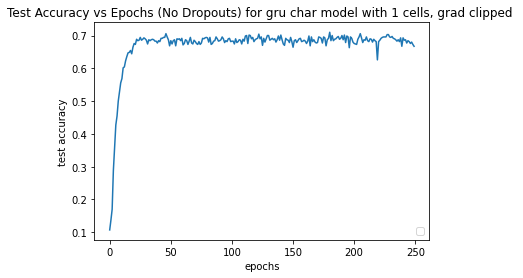

No handles with labels found to put in legend.


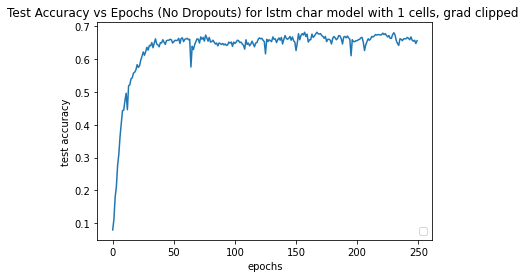

No handles with labels found to put in legend.


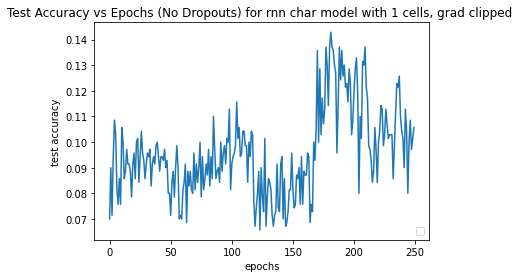

In [14]:
#Plot individuals test acc
for cell_type in cell_type_list:
  pylab.figure()
  pylab.plot(np.arange(no_epochs), test_acc_dict[cell_type])
  pylab.xlabel('epochs')
  pylab.ylabel('test accuracy')
  pylab.title('Test Accuracy vs Epochs (No Dropouts) for %s char model with %s cells, grad clipped '%(cell_type,cell_num))
  pylab.legend(loc='lower right')
  pylab.show()

No handles with labels found to put in legend.


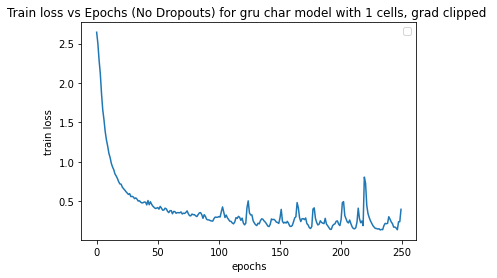

No handles with labels found to put in legend.


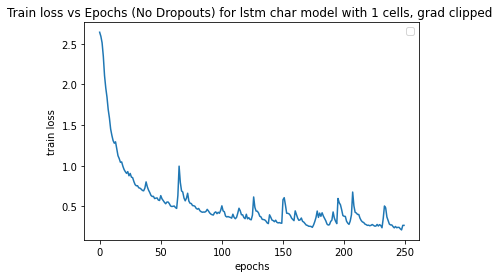

No handles with labels found to put in legend.


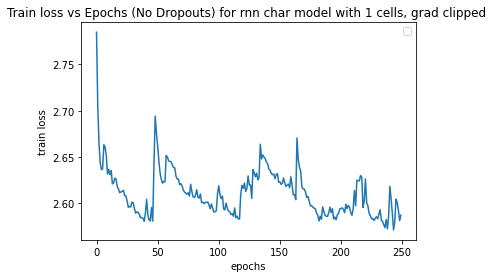

In [15]:
#Plot individual train loss
for cell_type in cell_type_list:
  pylab.figure()
  pylab.plot(np.arange(no_epochs), train_loss_dict[cell_type])
  pylab.xlabel('epochs')
  pylab.ylabel('train loss')
  pylab.title('Train loss vs Epochs (No Dropouts) for %s char model with %s cells, grad clipped '%(cell_type,cell_num))
  pylab.legend(loc='upper right')
  pylab.show()

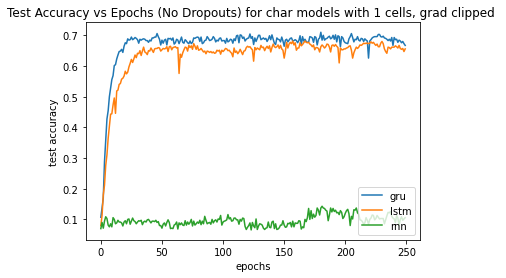

In [16]:
#Plot together test acc
pylab.figure()
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
for cell_type in cell_type_list:
    pylab.plot(np.arange(no_epochs), test_acc_dict[cell_type], label=cell_type)
pylab.title('Test Accuracy vs Epochs (No Dropouts) for char models with %s cells, grad clipped '%(cell_num))
pylab.legend(loc='lower right')
pylab.show()

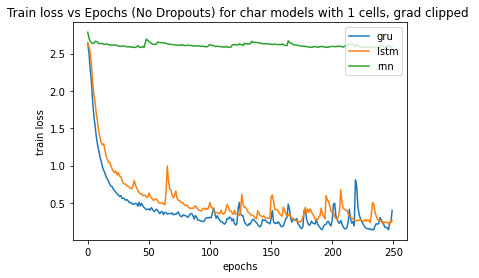

In [17]:
#Plot together train loss
pylab.figure()
for cell_type in cell_type_list:
  pylab.plot(np.arange(no_epochs), train_loss_dict[cell_type],label=cell_type)
pylab.xlabel('epochs')
pylab.ylabel('train loss')
pylab.title('Train loss vs Epochs (No Dropouts) for char models with %s cells, grad clipped '%(cell_num))
pylab.legend(loc='upper right')
pylab.show()